In [4]:
# WhatsApp Chat Analysis Report
# Overview
# This report presents an analysis of a WhatsApp chat conversation between members of the ADA Program Team Prime. The chat contains a total of 699 messages sent between  December 5th, 2022 and December 14th, 2022.

#importing the required libraries

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import wordcloud
import emoji
import itertools
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


In [13]:
#function to look get the messages dates
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def find_sender(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_sender(message):
        splitmessage = message.split(": ")
        sender = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        sender= None
    return date, time, sender, message


In [14]:
data = []
conversation = 'Prime_Chat.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, sender = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, sender, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, sender, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

In [22]:
#converting into dataframe
df = pd.DataFrame(data, columns=["Date", 'Time', 'Sender', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])
print(df.tail(5))
print(df.head(5))
print(df.info())
print(df.Sender.unique())



          Date     Time             Sender  \
694 2022-12-14  1:32 PM  +234 816 622 9879   
695 2022-12-14  1:34 PM  +234 818 359 8830   
696 2022-12-14  1:40 PM  +234 816 622 9879   
697 2022-12-14  2:19 PM  +234 705 959 2726   
698 2022-12-14  2:21 PM  +234 705 959 2726   

                                               Message  
694  Are we still designing the logo cos u changed ...  
695                                  We are doing both  
696  The due date u gave is too short and am not ch...  
697                                     Both are there  
698  You are not the only person doing it. I assign...  
        Date      Time              Sender  \
0 2022-12-05  12:47 PM                None   
1 2022-12-05  12:52 PM                None   
2 2022-12-05  12:58 PM                None   
3 2022-12-05  12:58 PM  Ifeanyi Team Delta   
4 2022-12-05  12:58 PM           camelCase   

                                       Message  
0  +234 701 103 0557 created group "Team Work"  
1     

In [23]:

df = df.dropna()

df= df.replace({'Sender': {
'Ifeanyi Team Delta':"Ifeanyi", 
'camelCase': 'Akeem', 
'+234 701 103 0557': "Abigail", 
 '+234 816 622 9879': 'Joy', 
 '+234 818 359 8830':'Aisha', 
 '+234 802 257 8007':'Kingsley',
 '+234 705 959 2726' :'Success',
 '+234 813 567 6808': 'Ibraheem', 
 '+234 806 226 1094':'Valentina',
 '+234 902 493 7385': 'Glory', 
 'Backend': 'Fransisca'}})

print(df.Sender.unique())


['Ifeanyi' 'Akeem' 'Abigail' 'Joy' 'Aisha' 'Kingsley' 'Success' 'Ibraheem'
 'Valentina' 'Glory' 'Fransisca']


In [24]:
# Insights
#1.Message Frequency
# The chat is mostly active on weekdays, with the highest number of messages sent on Monday 05/12/2022 and Monday 12/12/2022. The chat is least active on weekends, with the lowest number of messages sent on Fridays and Saturdays.



df['day'] = df['Date'].dt.strftime('%a')
df['month'] = df['Date'].dt.strftime('%b')
df['year'] = df['Date'].dt.year
df['date'] = df['Date'].apply(lambda x: x.date())

df1 = df.copy()      # using a copy of the original data frame, to avoid loss of data!

df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.

df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2022-12-05,233
1,2022-12-06,47
2,2022-12-07,44
3,2022-12-08,82
4,2022-12-09,40
5,2022-12-10,29
6,2022-12-11,77
7,2022-12-12,105
8,2022-12-13,9
9,2022-12-14,8


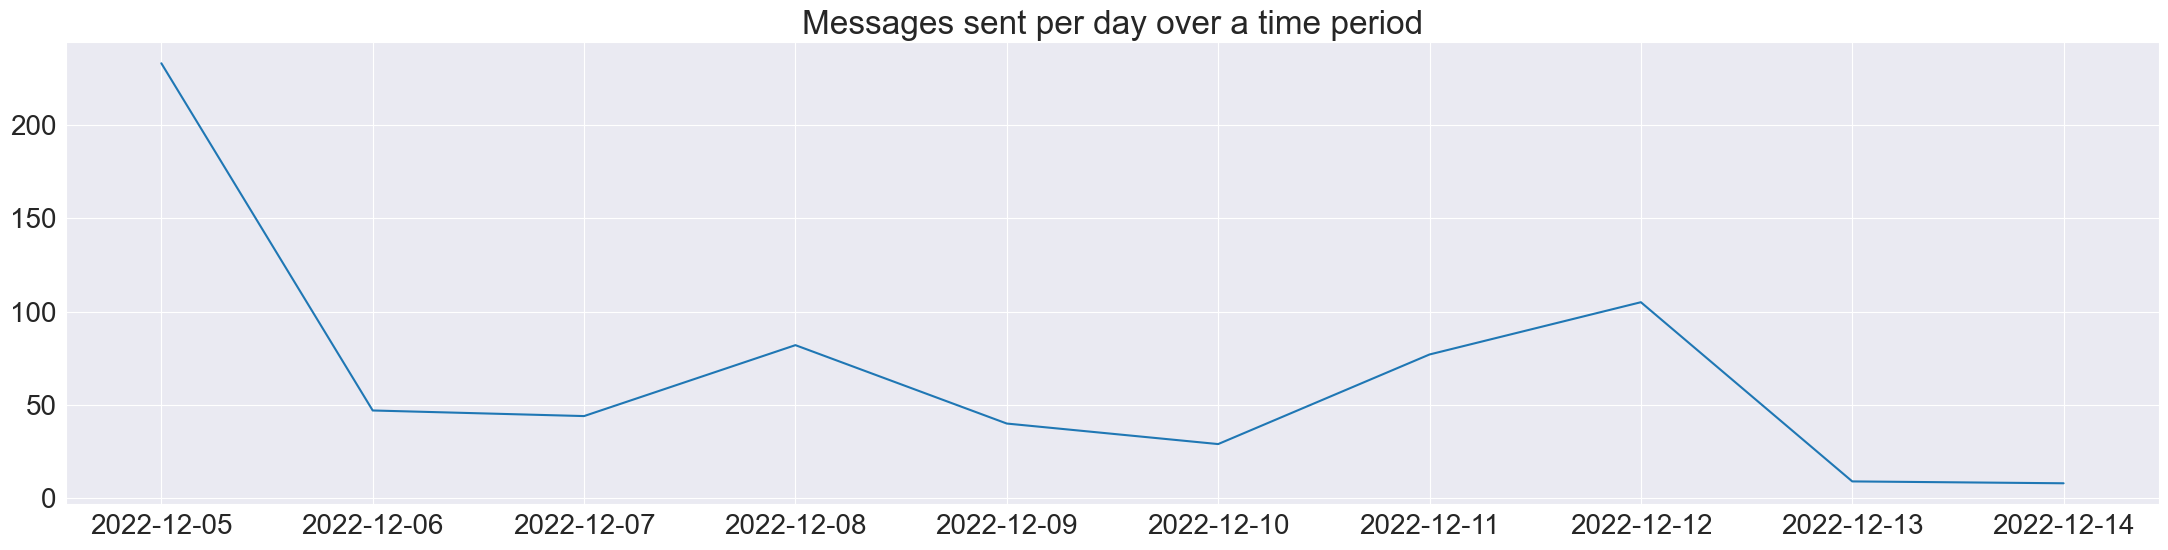

In [ ]:
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6) 


# the plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')


In [25]:
top3days = df1.sort_values(by="message_count", ascending=False).head(3)    # Sort values according to the number of messages per day.
top3days.reset_index(inplace=True)           # reset index in order.
top3days.drop(columns="index", inplace=True) # dropping original indices.
top3days

,date,message_count
0,2022-12-05,233
1,2022-12-12,105
2,2022-12-08,82


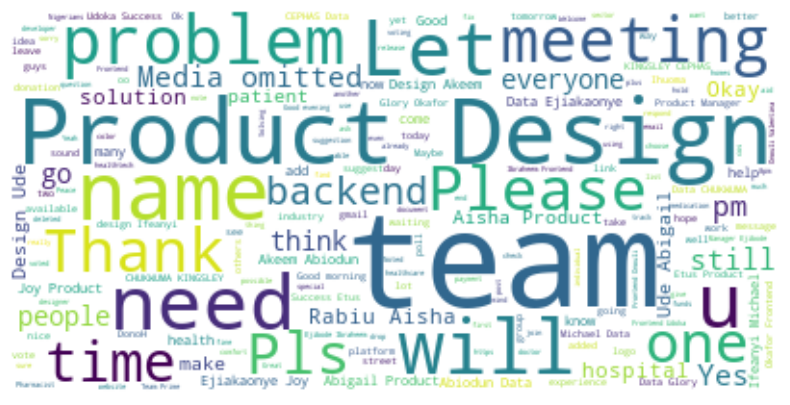

In [18]:

#2. Popular Words
# The most commonly used words in the chat include "Product Design", "team", "meeting", "time", and"problem". These words suggest that the group is focused on work-related topics.

### Wordcloud of mostly used words in the chat
from wordcloud import WordCloud, STOPWORDS
text = " ".join(review for review in df.Message)
WordCloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(WordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
### Creates a list of unique Senders
l = df.Sender.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = df[df["Sender"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])


None   ->   0
Ifeanyi Team Delta   ->   62
camelCase   ->   116
+234 701 103 0557   ->   137
+234 816 622 9879   ->   41
+234 818 359 8830   ->   42
+234 802 257 8007   ->   16
+234 705 959 2726   ->   142
+234 813 567 6808   ->   51
+234 806 226 1094   ->   22
+234 902 493 7385   ->   20
Backend   ->   25


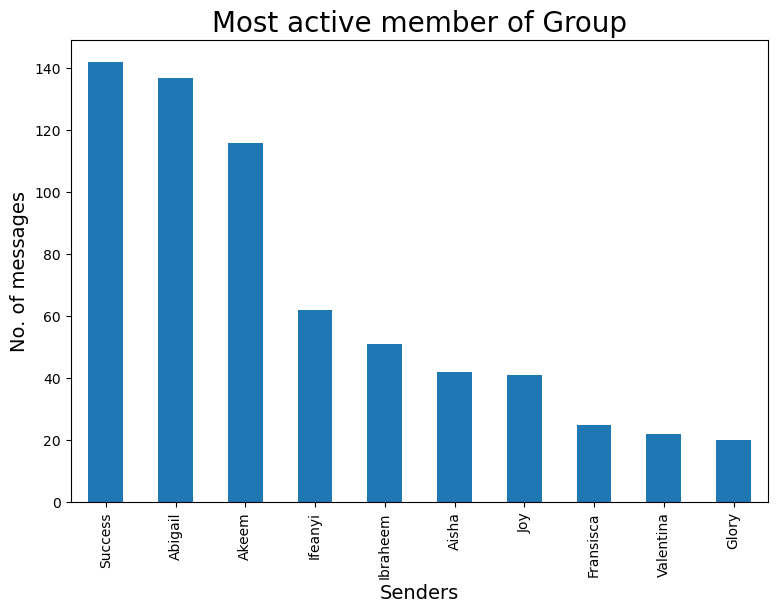

In [26]:

#3. Active Members
# There are 11 members in the group chat. The most active member is Success( Team Lead) with 142 messages, followed by Abigail with 137 messages and Akeem with 116 messages

## Most Active Members in the Group
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
mostly_active = df['Sender'].value_counts()
### Top 10 people that are most active in the Group are : 
m_a = mostly_active.head(10)
bars = m_a.index

x_pos = np.arange(len(bars))
m_a.plot.bar()
plt.xlabel('Senders',fontdict={'fontsize': 14,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 14,'fontweight': 10})
plt.title('Most active member of Group',fontdict={'fontsize': 20,'fontweight': 8})
plt.xticks(x_pos, bars)
plt.show()




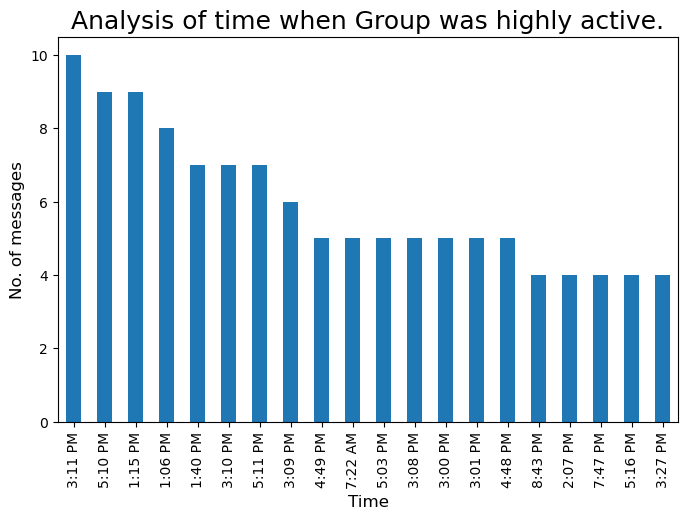

In [27]:
### Time whenever our group is highly active
#The time when the team  was most active in the chat was 3.11 pm with 10

plt.figure(figsize=(8,5))
t = df['Time'].value_counts().head(20)
tx = t.plot.bar()

plt.xlabel('Time',fontdict={'fontsize': 12,'fontweight': 10})
plt.ylabel('No. of messages',fontdict={'fontsize': 12,'fontweight': 10})
plt.title('Analysis of time when Group was highly active.',fontdict={'fontsize': 18,'fontweight': 8})
plt.show()
